# Trace Overlap
a. stein 5.3.2023

Here I want to pick an event in time and collect all the nodes forward and backwards that then describe the evolution of that drought.

In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network_v12 as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/drought_threads/../../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dnet_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [3]:
exp_tag = 'f25k_d1_rt20p_paired'

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/USDM_net_{exp_tag}.pickle')

In [5]:
spi30d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_30d_net_{exp_tag}.pickle')

In [6]:
spi180d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_180d_net_{exp_tag}.pickle')

In [7]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

## Major SPI180d Drought

id 1517 has the largest drought event happening in spi180d, which happens at time 900

In [8]:
paired_ds['SPI Date'].sel(index=900)

<xarray.DataArray 'SPI Date' ()>
array('2017-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    index    int64 900

In [9]:
spi180d_trace = spi180d_net.nodes[1517]
spi180d_trace

time: 900, id: 1517

In [10]:
origin_paths_spi180d = [spi180d_net.nodes[id] for id in spi180d_net.collect_origin_paths(start_id=1517)]

In [11]:
len(origin_paths_spi180d)

81

In [12]:
len(list(set([node.id for node in origin_paths_spi180d])))

81

In [13]:
future_paths_spi180d = spi180d_net.get_chronological_future_thread(id=1517)

In [14]:
len(future_paths_spi180d)

46

In [15]:
len(list(set([node.id for node in future_paths_spi180d])))

46

In [16]:
total_paths_spi180d = origin_paths_spi180d.copy()
total_paths_spi180d.extend(future_paths_spi180d)

In [17]:
spi180d_trace in origin_paths_spi180d

False

In [18]:
spi180d_trace in future_paths_spi180d

True

In [19]:
spi180d_trace in total_paths_spi180d

True

Cool, now we got all the nodes for that trace

Now let's do the same for the intersecting spi30d

In [20]:
spi30d_trace = [spi30d_net.nodes[id] for id in [1801, 1802, 1803]]

In [21]:
origin_paths_spi30d = []
for trace in spi30d_trace:
    op = [spi30d_net.nodes[id] for id in spi30d_net.collect_origin_paths(start_id=trace.id)]
    origin_paths_spi30d.extend(op)

In [22]:
len(origin_paths_spi30d)

75

In [23]:
len(list(set([node.id for node in origin_paths_spi30d])))

41

In [24]:
future_paths_spi30d = []
for trace in spi30d_trace:
    fp = spi30d_net.get_chronological_future_thread(id=trace.id)
    future_paths_spi30d.extend(fp)

In [25]:
len(future_paths_spi30d)

35

In [26]:
len(list(set([node.id for node in future_paths_spi30d])))

17

THERE MUST BE A CULLING!

In [27]:
total_paths_spi30d = origin_paths_spi30d.copy()
total_paths_spi30d.extend(future_paths_spi30d)

In [28]:
total_paths_spi30d_pruned = []
ids_found = []
for node in total_paths_spi30d:
    if node.id not in ids_found:
        total_paths_spi30d_pruned.append(node)
        ids_found.append(node.id)

In [29]:
len(total_paths_spi30d_pruned)

58

In [30]:
def get_full_thread(net, nodes):
    origin_paths = []
    for trace in nodes:
        op = [net.nodes[id] for id in net.collect_origin_paths(start_id=trace.id)]
        origin_paths.extend(op)

    future_paths = []
    for trace in nodes:
        fp = net.get_chronological_future_thread(id=trace.id)
        future_paths.extend(fp)
    total_paths = origin_paths.copy()
    total_paths.extend(future_paths)

    pruned = []
    ids_found = []
    for node in total_paths:
        if node.id not in ids_found:
            pruned.append(node)
            ids_found.append(node.id)

    return pruned

In [31]:
test = get_full_thread(spi30d_net, spi30d_trace)

In [32]:
len(test)

58

In [33]:
test == total_paths_spi30d

False

In [34]:
test == total_paths_spi30d_pruned

True

In [35]:
total_paths_spi30d = total_paths_spi30d_pruned

In [36]:
def overlap_nodes(nodes_a, nodes_b):
        """Find overlapping nodes with another DroughtNetwork.

        Parameters
        ----------
        b: DroughtNetwork
        matched_dates_dict_idx: dict
            Map going from the time indices in a DroughtNetwork as
            keys and b DroughtNetwork as values.
        
        Returns
        -------
        list[dict]
            List of event threads that overlap between a and b,
            where each element in the list is a dictionary mapping
            what nodes are overlapping between the two DroughtNetworks
            with the times of a as keys.

            [[{a.time:[[a_overlapping_node, b_overlapping_node], ...]}], ...]

        """

        overlapped_nodes = dict()

        for node_a in tqdm(nodes_a):
            # first need to see if the node's time is a matched time
            time_idx = node_a.time
            # will be testing overlap via set intersection
            node_a_coord_set = set(tuple(coord) for coord in node_a.coords)
            for node_b in nodes_b:
                # if it's a temporal match
                if time_idx == node_b.time:
                    # then we'll carry through testing for spatial intersection
                    node_b_coord_set = set(tuple(coord) for coord in node_b.coords)                        
                    if len(node_a_coord_set.intersection(node_b_coord_set)) > 0:
                        if time_idx not in overlapped_nodes.keys():
                            overlapped_nodes[time_idx] = []
                        overlapped_nodes[time_idx].append([node_a, node_b])

        overlap_events = []

        # okay, now to figure out which are the temporally consecutive
        # events to have delineations between overlaps
        current_event = []
        for idx in overlapped_nodes.keys():
            # if we currently aren't constructing an event,
            # then we must be starting from scratch and will
            # just toss it on to get started
            if len(current_event) == 0:
                current_event.append({idx:overlapped_nodes[idx]})
            # now we want to see if they're consecutive
            elif list(current_event[-1].keys())[0] == idx -1:
                current_event.append({idx:overlapped_nodes[idx]})
            # if they aren't consecutive, then we need to
            # store the current event we were working on
            # and start from scratch
            else:
                overlap_events.append(current_event)
                current_event = [{idx:overlapped_nodes[idx]}]
        
        # lastly, if the final time is consecutive, then we
        # won't end up storing in our events, so we should
        # check whether it got stored and store it if not
        if len(current_event) != 0 and overlap_events[-1] != current_event:
            overlap_events.append(current_event)


        return overlap_events

In [37]:
on_spi180d_spi30d = overlap_nodes(total_paths_spi180d, total_paths_spi30d)

  0%|          | 0/127 [00:00<?, ?it/s]

In [38]:
on_spi180d_spi30d

[[{899: [[time: 899, id: 1515, time: 899, id: 1799],
    [time: 899, id: 1515, time: 899, id: 1800]]}],
 [{898: [[time: 898, id: 1513, time: 898, id: 1795],
    [time: 898, id: 1513, time: 898, id: 1796],
    [time: 898, id: 1513, time: 898, id: 1797]]}],
 [{897: [[time: 897, id: 1510, time: 897, id: 1791],
    [time: 897, id: 1510, time: 897, id: 1792],
    [time: 897, id: 1510, time: 897, id: 1793]]}],
 [{896: [[time: 896, id: 1506, time: 896, id: 1790]]}],
 [{895: [[time: 895, id: 1503, time: 895, id: 1788],
    [time: 895, id: 1503, time: 895, id: 1789]]}],
 [{894: [[time: 894, id: 1498, time: 894, id: 1783],
    [time: 894, id: 1498, time: 894, id: 1784],
    [time: 894, id: 1498, time: 894, id: 1785],
    [time: 894, id: 1498, time: 894, id: 1786]]}],
 [{893: [[time: 893, id: 1494, time: 893, id: 1776],
    [time: 893, id: 1494, time: 893, id: 1778],
    [time: 893, id: 1494, time: 893, id: 1779],
    [time: 893, id: 1494, time: 893, id: 1780]]}],
 [{892: [[time: 892, id: 1490, t

In [39]:
aa_spi180d_spi30d = dnet.compute_alignment_area(on_spi180d_spi30d)

In [40]:
aa_spi180d_spi30d

[{899: 25861},
 {898: 27190},
 {897: 33283},
 {896: 50610},
 {895: 54341},
 {894: 40419},
 {893: 37833},
 {892: 39948},
 {891: 41271},
 {890: 41518},
 {889: 33015},
 {888: 45940},
 {887: 15496},
 {886: 19828},
 {885: 8568},
 {884: 2070},
 {883: 611},
 {882: 381},
 {881: 241},
 {900: 36464,
  901: 31211,
  902: 39624,
  903: 44690,
  904: 35299,
  905: 35667,
  906: 6510,
  907: 8948}]

In [41]:
pre_sort_times = np.hstack([list(pairing.keys()) for pairing in aa_spi180d_spi30d])
pre_sort_times

array([899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888, 887,
       886, 885, 884, 883, 882, 881, 900, 901, 902, 903, 904, 905, 906,
       907])

In [42]:
post_sort_times = np.sort(pre_sort_times)
post_sort_times

array([881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893,
       894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906,
       907])

In [43]:
aa_spi180d_spi30d_all = dict()
for pairing in aa_spi180d_spi30d:
    aa_spi180d_spi30d_all.update(pairing)
aa_spi180d_spi30d_all

{899: 25861,
 898: 27190,
 897: 33283,
 896: 50610,
 895: 54341,
 894: 40419,
 893: 37833,
 892: 39948,
 891: 41271,
 890: 41518,
 889: 33015,
 888: 45940,
 887: 15496,
 886: 19828,
 885: 8568,
 884: 2070,
 883: 611,
 882: 381,
 881: 241,
 900: 36464,
 901: 31211,
 902: 39624,
 903: 44690,
 904: 35299,
 905: 35667,
 906: 6510,
 907: 8948}

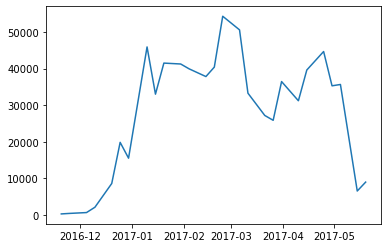

In [44]:
fig, ax = plt.subplots()

times = post_sort_times
dates = paired_ds['SPI Date'].sel(index=times).values

ax.plot(
    dates, 
    np.hstack([aa_spi180d_spi30d_all[time] for time in times]))

In [45]:
spi180d_da, spi30d_da = dnet.compute_disagreement_area(spi180d_net, spi30d_net, on_spi180d_spi30d)

In [46]:
area_mult = 18.1 # km2

In [47]:
spi180d_da_sel = []
for time in times:
    try:
        spi180d_da_sel.append(spi180d_da[time]*area_mult)
    except:
        spi180d_da_sel.append(0)

In [48]:
spi30d_da_sel = []
for time in times:
    try:
        spi30d_da_sel.append(spi30d_da[time]*area_mult)
    except:
        spi30d_da_sel.append(0)

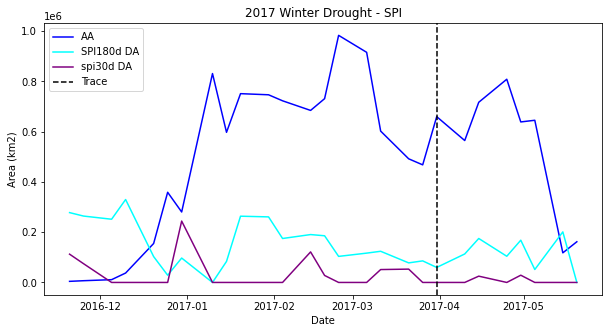

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

times = post_sort_times
dates = paired_ds['SPI Date'].sel(index=times).values

trace_time = paired_ds['SPI Date'].sel(index=900).values

ax.plot(
    dates, 
    np.hstack([aa_spi180d_spi30d_all[time]*area_mult for time in times]), label='AA', color='b')

ax.plot(dates, spi180d_da_sel, label='SPI180d DA', color='cyan')
ax.plot(dates, spi30d_da_sel, label='spi30d DA', color='purple')

ax.axvline(trace_time, color='k', label='Trace', linestyle='--')

ax.set_title('2017 Winter Drought - SPI')
ax.legend()
ax.set_ylabel('Area (km2)')
ax.set_xlabel('Date')
fig.set_facecolor('w')

Now we have a workflow, nice.

In [50]:
spi180d_areas = dict()

for node in total_paths_spi180d:
    if not node.time in spi180d_areas.keys():
        spi180d_areas[node.time] = 0
    spi180d_areas[node.time] += len(node.coords)*area_mult

In [51]:
spi180d_areas

{899: 1489195.6,
 898: 1457936.9000000001,
 897: 1552762.8,
 896: 1456977.6,
 895: 1458660.9000000001,
 894: 1390785.9000000001,
 893: 1279633.8,
 892: 1112534.6,
 891: 1125150.3000000003,
 890: 1134526.1,
 889: 1043446.9000000001,
 888: 1097837.4000000001,
 887: 679130.1,
 886: 784942.7000000001,
 885: 742787.8,
 884: 613915.8,
 883: 423938.2,
 882: 387901.10000000003,
 881: 390217.9,
 880: 440011.0,
 879: 539832.5,
 878: 610567.3,
 877: 347320.9,
 876: 246576.30000000002,
 875: 142356.5,
 874: 104618.00000000001,
 873: 110156.6,
 872: 56417.700000000004,
 871: 56001.4,
 870: 57883.8,
 869: 53992.3,
 868: 65304.8,
 867: 68418.0,
 866: 66933.8,
 865: 67332.0,
 864: 64798.00000000001,
 863: 68707.6,
 862: 45250.0,
 861: 44688.9,
 860: 44435.5,
 859: 67060.5,
 858: 64200.700000000004,
 857: 94246.70000000001,
 856: 106735.70000000001,
 855: 327284.2,
 854: 322053.30000000005,
 853: 320840.60000000003,
 852: 374851.00000000006,
 851: 290342.10000000003,
 850: 231517.10000000003,
 849: 124

In [52]:
spi30d_areas = dict()

for node in total_paths_spi30d:
    if not node.time in spi30d_areas.keys():
        spi30d_areas[node.time] = 0
    spi30d_areas[node.time] += len(node.coords)*area_mult

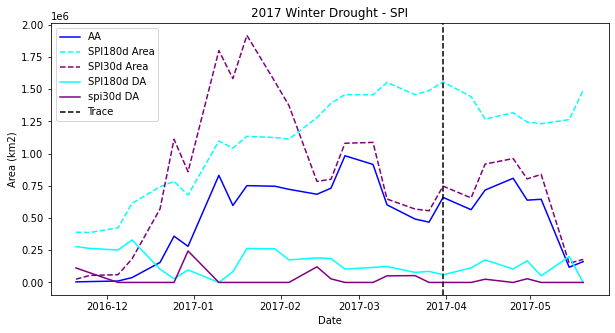

In [53]:
fig, ax = plt.subplots(figsize=(10,5))

times = post_sort_times
dates = paired_ds['SPI Date'].sel(index=times).values

trace_time = paired_ds['SPI Date'].sel(index=900).values

ax.plot(
    dates, 
    np.hstack([aa_spi180d_spi30d_all[time]*area_mult for time in times]), label='AA', color='b')

ax.plot(
    dates,
    np.hstack([spi180d_areas[time] for time in times]), label='SPI180d Area', color='cyan', linestyle='--'
)
ax.plot(
    dates,
    np.hstack([spi30d_areas[time] for time in times]), label='SPI30d Area', color='purple', linestyle='--'
)

ax.plot(dates, spi180d_da_sel, label='SPI180d DA', color='cyan')
ax.plot(dates, spi30d_da_sel, label='spi30d DA', color='purple')

ax.axvline(trace_time, color='k', label='Trace', linestyle='--')

ax.set_title('2017 Winter Drought - SPI')
ax.legend()
ax.set_ylabel('Area (km2)')
ax.set_xlabel('Date')
fig.set_facecolor('w')

Let's double check these with some spatial plots

In [54]:
def node_array(net, nodes, start_time, end_time):
    array_out = np.zeros(((end_time-start_time)+1, net.data.shape[1], net.data.shape[2]))

    for node in nodes:
        if node.time <= end_time and node.time >= start_time:
            t = node.time - start_time
            for [i, j] in node.coords:
                array_out[t, i, j] += 1
    
    return array_out

In [55]:
spi30d_array = node_array(spi30d_net, total_paths_spi30d, post_sort_times[0], post_sort_times[-1])

In [56]:
spi30d_array.shape

(27, 702, 525)

In [57]:
spi180d_array = node_array(spi180d_net, total_paths_spi180d, post_sort_times[0], post_sort_times[-1])

In [58]:
spi180d_array.shape

(27, 702, 525)

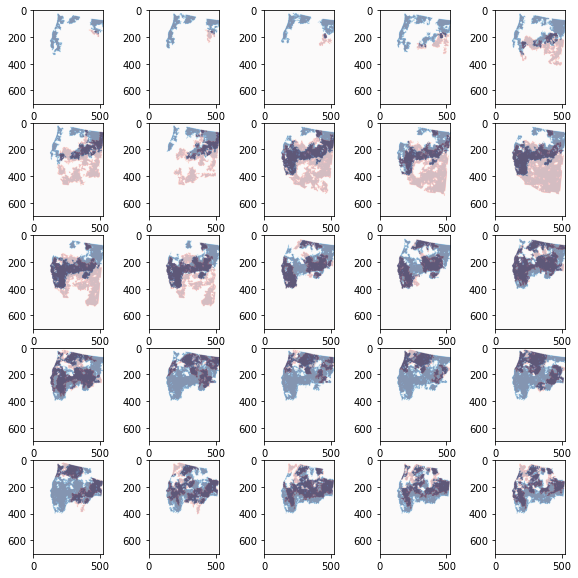

In [59]:
fig, axs = plt.subplots(5,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi30d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(spi180d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

In [60]:
spi30d_array.sum()*area_mult

21879877.3

In [61]:
np.sum(list(spi30d_areas.values()))

21879877.3

In [62]:
43707807.6/43707807.60000001

0.9999999999999998

In [63]:
combined_array = spi30d_array + spi180d_array

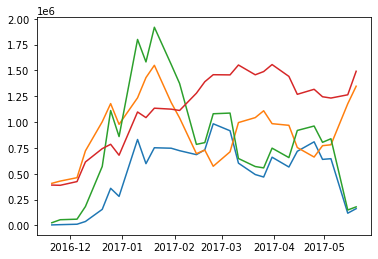

In [64]:
fig, ax = plt.subplots()

ax.plot(dates, (combined_array == 2).sum(axis=(1,2))*area_mult)
ax.plot(dates, (combined_array == 1).sum(axis=(1,2))*area_mult)
ax.plot(dates, spi30d_array.sum(axis=(1,2))*area_mult)
ax.plot(dates, spi180d_array.sum(axis=(1,2))*area_mult)

In [65]:
set(spi30d_array.ravel())

{0.0, 1.0}

In [66]:
ids = []

for node in total_paths_spi30d:
    ids.append(node.id)

In [67]:
len(ids)

58

In [68]:
len(list(set(ids)))

58